
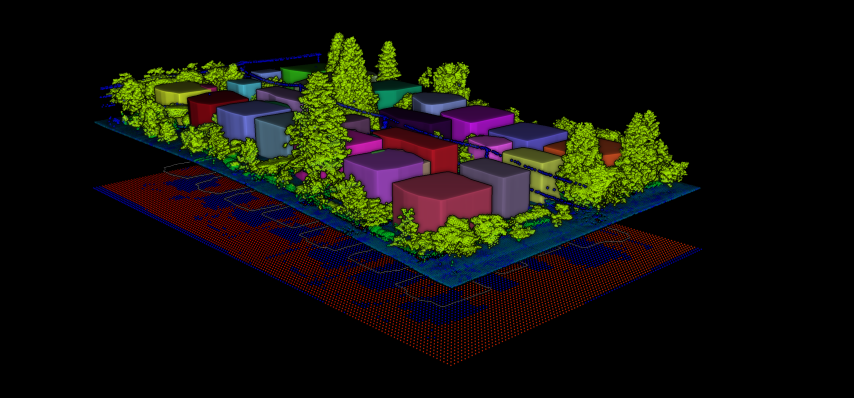

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d as o3d
import laspy
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon
import random


# Phase 1. Environment Preparation 🍇
1. Virtual Environment Setup with Python
2. Install libraries: numpy, matplotlib, pandas, open3d, laspy[lazrs,laszip], rasterio, alphashape, geopandas, shapely
3. Install IDE + Launch our Script

In [1]:
#%% 1. Aerial Lidar Vectorization: Implementation Setup

#Base libraries

#3D Libraries
print(laspy.__version__)

#Geospatial libraries



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.0


# Phase 2. Data Preparation 🍉
1. Aerial LiDAR Data Curation: [Vancouver Portal](https://opendata.vancouver.ca/explore/dataset/lidar-2022/map/?location=13,49.23944,-123.12768) | [.laz sample (Google Drive)](https://drive.google.com/drive/folders/1K80h_oAKbB-7cO5jNsvvG09TIBnzQy7t?usp=sharing)
2. Data Profiling
3. Data Pre-Processing

Classes in the Point Cloud
1. Unclassified
2. Bare-earth and low grass
3. Low vegetation (height <2m
4. High vegetation (height >m)
5. Water
6. Buildings
7. Others
8. 
Noise (noise points, blunders, outliners, es, etc)

In [2]:
#%% 2. Data Profiling

#neighborhood point cloud
las = laspy.read('../DATA/neighborhood.laz')

#single building

#explore the classification field
print(np.unique(las.classification))
print([dimension.name for dimension in las.point_format.dimensions])

#explore CRS info
crs = las.vlrs[2].string
print(las.vlrs[2].string)

[1 2 3 5 6 7]
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']
PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0],AUTHORITY["EPSG",26910]]


In [3]:
#%% 3. Data Pre-Processing

#%% 3.1.  Building points initialization
# Create a Mask to filter points
pts_mask = las.classification == 6

#Apply the mask and get the coordinates of the filtered dataset (note the t for transpose)
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

#transform to Open3D.o3d.geometry.PointCloud and visualize
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz_t.transpose())

#translate the point cloud, and keep the translation to reapply at the end
pcd_center = pcd_o3d.get_center()
pcd_o3d.translate(-pcd_center)

#Visualize the results
o3d.visualization.draw_geometries([pcd_o3d])

In [4]:
#%% 3.1. Isolating ground points
pts_mask = las.classification == 2
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

ground_pts = o3d.geometry.PointCloud()
ground_pts.points = o3d.utility.Vector3dVector(xyz_t.transpose())
ground_pts.translate(-pcd_center)

#Visualize the results
o3d.visualization.draw_geometries([ground_pts])

In [5]:
#%% 3.2. Identifying the average distance between building points
nn_distance = np.mean(pcd_o3d.compute_nearest_neighbor_distance())
print("average point distance (m): ", nn_distance)

average point distance (m):  0.11673857611056317


# Phase 3. Single Unit Experiments 🍏
4. Unsupervised segmentation
5. 3D House Segmentation
6. 2D Building Footprint Extraction
7. Semantic and Attribute Extraction
8. 2D to 3D Vectors
9. 3D Model Creation (vertices)
10. 3D Model Creation (meshes)
11. Post-Processing and Export

In [6]:
#%% 4. Unsupervised Segmentation (Clustering) with DBSCAN
#We are now working in a local frame of reference, essential not to get stuck at truncated coordinates

#Definition of the parameters epsilon, and the minimum number of points to be considered a relevant cluster
epsilon = 2
min_cluster_points = 100

labels = np.array(pcd_o3d.cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")


#We use a discrete color palette to randomize the visualization
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])

#Point Cloud Visualization
o3d.visualization.draw_geometries([pcd_o3d])

point cloud has 31 clusters


In [11]:
#%% 5. Selecting a segment to be considered
sel = 1
segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])
o3d.visualization.draw_geometries([segment])

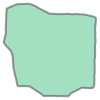

In [12]:
#%% 6. Extracting the outline (building footprint) of the selection

#We extract only the X and Y coordinates of our point cloud (Note: it is local)
points_2D = np.asarray(segment.points)[:,0:2]

#We compute the shape (alpha shape) and return the result with shapely
building_vector = ash.alphashape(points_2D, alpha=0.5)
building_vector

In [13]:
#%% Store in a Geodataframe the 2D polygon
building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
building_gdf.head(1)

,geometry
0,"POLYGON ((-42.952 -15.990, -42.499 -16.049, -4..."


In [14]:
#%% 7. Computing semantics and attributes

#%% 7.1. The height of the building as a relative measure

#What is wrong with this line?
altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
height_test = np.max(altitude)- np.min(altitude)
print('Is this correct: ',height_test)

#We first have to define the ground level in our local area
query_point = segment.get_center()
query_point[2] = segment.get_min_bound()[2]
pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
[k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 200)

#From the nn search, we extract the points that belong to the ground and paint them grey
sample = ground_pts.select_by_index(idx, invert=False)
sample.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([sample, ground_pts])

#Extract the mean value of the ground in this specific place
ground_zero = sample.get_center()[2]

#Compute the true height of the building, roof included:
height = segment.get_max_bound()[2] - ground_zero
print('True Height: ', height)

#Check the difference: 
print('Height Difference: ', height - height_test)

Is this correct:  10.192000000000007
True Height:  10.070570000000004
Height Difference:  -0.1214300000000037


In [15]:
#%%7.2. Computing parameters
building_gdf[['id']] = sel
building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
building_gdf[['area']] = building_vector.area
building_gdf[['perimeter']] = building_vector.length
building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
building_gdf[['pts_number']] = len(segment.points)

#print
building_gdf.head(1)

,geometry,id,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,"POLYGON ((-42.952 -15.990, -42.499 -16.049, -4...",1,10.07057,217.271398,58.079869,-43.39485,-22.418669,-4.426159,490276.695828,5.453749e+06,109.171589,7747


The local minima (along the Z axis) -4.54758912976655
The local maxima (along the Z axis) 5.6444108702334574


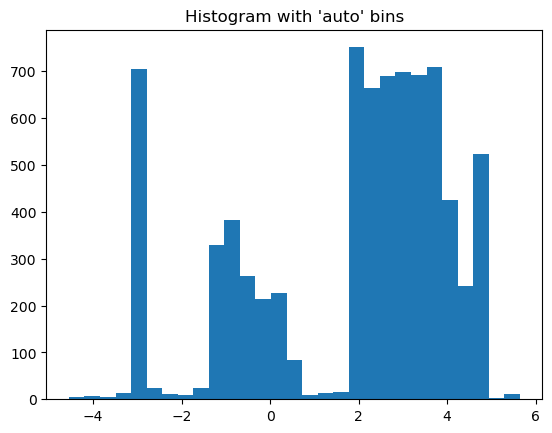

In [16]:
#%%7.3 Extra attributes
points_1D = np.asarray(segment.points)[:,2]
print('The local minima (along the Z axis)',np.min(points_1D))
print('The local maxima (along the Z axis)',np.max(points_1D))

plt.hist(points_1D, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [17]:
o3d.visualization.draw_geometries([segment])

In [18]:
#8. 2D to 3D Library: From a shapely Vector dataset to an Open3D LineSet
#8.1. The base layer
#Generate the vertice list
vertices = list(building_vector.exterior.coords)

#Construct the Open3D Object
polygon_2d = o3d.geometry.LineSet()
polygon_2d.points = o3d.utility.Vector3dVector([point + (0,) for point in vertices])
polygon_2d.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])

#Visualization
o3d.visualization.draw_geometries([polygon_2d])

In [19]:
#8.2. The top layer
#Generate the same element for the Extruded
extrusion = o3d.geometry.LineSet()
extrusion.points = o3d.utility.Vector3dVector([point + (height,) for point in vertices])
extrusion.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])
o3d.visualization.draw_geometries([polygon_2d, extrusion])

#Plot the vertices
temp = polygon_2d + extrusion
temp.points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = temp.points
o3d.visualization.draw_geometries([temp_o3d])

In [20]:
#9. Generating the base vertices for the 3D Mesh with Numpy
a = np.array(building_vector.exterior.coords)
b = np.ones([a.shape[0],1])*sample.get_center()[2]
c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)

#Define the ground footprint and the height arrays of points
ground_pc = np.hstack((a, b))
up_pc = np.hstack((a, c))

#Generate an Open3D "point cloud" made of the major points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
o3d.visualization.draw_geometries([temp_o3d])

In [21]:
#10. Computing the alpha Shape of the 3D base points
alpha = 20
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5,0.4,0])
o3d.visualization.draw_geometries([temp_o3d, mesh, segment], mesh_show_back_face=True)

alpha=20.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra

In [22]:
#11. Post-Processing Operations & Export
#Repositioning the mesh from local to the world coordinates
mesh.translate(pcd_center)

#Export the Mesh
o3d.io.write_triangle_mesh('../RESULTS/house_sample.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False, write_vertex_colors=False, write_triangle_uvs=False)

#Export the shapefile
building_gdf.to_file("../RESULTS/single_building.shp")


# Phase 4. 3D Automation and Scaling 🍌

In [23]:
#12. Automation and Scaling 3D City Modelling

# Optional utility
def random_color_generator():
    """Random color generator function."""
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return [r/255, g/255, b/255]

#Initializing the GeodataFrame
buildings_gdf = gpd.GeoDataFrame(columns=['id', 'geometry', 'height', 'area', 'perimeter', 'local_cx', 'local_cy', 'local_cz', 'transl_x', 'transl_y', 'transl_z'], geometry='geometry', crs='EPSG:26910')

# Reducing the output wave of Open3D
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

#Creating the loop
for sel in range(max_label+1):
    #1. Select the Segment
    segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])
    # o3d.visualization.draw_geometries([segment])

    #2. Compute the building footprint
    # altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
    points_2D = np.asarray(segment.points)[:,0:2]
    building_vector = ash.alphashape(points_2D, alpha=0.5)
    
    #3. Compute the height of the segment (house candidate).
    query_point = segment.get_center()
    query_point[2] = segment.get_min_bound()[2]
    pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
    [k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 50)
    sample = ground_pts.select_by_index(idx, invert=False)
    ground_zero = sample.get_center()[2]
    
    #4. Create the geopandas with attributes entry
    building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
    building_gdf[['id']] = sel
    building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
    building_gdf[['area']] = building_vector.area
    building_gdf[['perimeter']] = building_vector.length
    building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
    building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
    building_gdf[['pts_number']] = len(segment.points)
    
    #4. Add it to geometries entries
    buildings_gdf = pd.concat([buildings_gdf, building_gdf])

#5. Compute the 3D Vertices Geometries
    a = np.array(building_vector.exterior.coords)
    b = np.ones([a.shape[0],1])*sample.get_center()[2]
    c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)
    ground_pc = np.hstack((a, b))
    up_pc = np.hstack((a, c))
    temp_o3d = o3d.geometry.PointCloud()
    temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
    
    #5. Compute the 3D Geometry of a house 
    alpha = 20
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
    mesh.translate(pcd_center)
    mesh.paint_uniform_color(random_color_generator())    #5. Compute the 3D Vertices Geometries

    
    o3d.io.write_triangle_mesh('../RESULTS/house_'+str(sel)+'.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False)

C:\Users\flore\AppData\Local\Temp\ipykernel_96096\4084733693.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  buildings_gdf = pd.concat([buildings_gdf, building_gdf])


In [24]:
buildings_gdf.head(5)

,id,geometry,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,0,"POLYGON ((-70.127 -28.661, -70.197 -28.530, -7...",8.22666,220.044376,58.509767,-65.353656,-21.865790,-4.354249,490276.695828,5.453749e+06,109.171589,7835.0
0,1,"POLYGON ((-42.952 -15.990, -42.499 -16.049, -4...",10.01868,217.271398,58.079869,-43.394850,-22.418669,-4.374269,490276.695828,5.453749e+06,109.171589,7747.0
0,2,"POLYGON ((-67.175 14.134, -67.244 13.334, -67....",3.77992,56.046655,28.919532,-70.892099,12.992831,-4.224509,490276.695828,5.453749e+06,109.171589,1850.0
0,3,"POLYGON ((-61.049 -6.239, -61.815 -6.460, -62....",3.43800,73.891078,33.293933,-59.835566,-2.574601,-4.319589,490276.695828,5.453749e+06,109.171589,2182.0
0,4,"POLYGON ((-62.549 -13.829, -62.043 -13.714, -6...",3.37544,19.282685,20.628842,-60.202507,-15.640869,-4.051029,490276.695828,5.453749e+06,109.171589,335.0


In [25]:
#Exporting the geometry are in a local frame of reference
buildings_gdf.to_file("../RESULTS/neighborhood_buildings.shp")

# Phase 5. Visualization and Rasterization 🥭

In [26]:
#13. A Raster Variant

pixel_size = 1

x, y, z = xyz_t[0], xyz_t[1], xyz_t[2]

# Determine the extent of the DEM
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

# Calculate the number of pixels in X and Y directions
num_pixels_x = int((max_x - min_x) / pixel_size)
num_pixels_y = int((max_y - min_y) / pixel_size)

#profile the results
print("number of pixel along X and Y: ",num_pixels_x, num_pixels_y)

number of pixel along X and Y:  166 93


In [27]:
# Create a transformation for the GeoTIFF
transform = from_origin(min_x, max_y, pixel_size, pixel_size)

# Create an array to store the elevation values
dem_array = np.zeros((num_pixels_y, num_pixels_x), dtype=np.float32)

In [28]:
# Convert X, Y coordinates to pixel indices
col_indices = ((x - min_x) / pixel_size).astype(int)
row_indices = ((max_y - y) / pixel_size).astype(int)

# Mask to ensure indices are within bounds
valid_indices = (0 <= row_indices) & (row_indices < num_pixels_y) & (0 <= col_indices) & (col_indices < num_pixels_x)

# Populate the DEM array with elevation values from the point cloud
dem_array[row_indices[valid_indices], col_indices[valid_indices]] = z[valid_indices]


In [29]:
dem_array

array([[  0.   ,   0.   ,   0.   , ...,  99.073,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,  99.084,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,  99.089,   0.   ,   0.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ..., 100.122, 100.109, 100.084],
       [  0.   ,   0.   ,   0.   , ..., 100.13 , 100.12 , 100.104],
       [  0.   ,   0.   ,   0.   , ..., 100.146, 100.136, 100.121]],
      dtype=float32)

In [30]:
# Save the DEM as a GeoTIFF file
with rasterio.open("../RESULTS/output_dem.tif", 'w', driver='GTiff', height=num_pixels_y, width=num_pixels_x,
                   count=1, dtype=np.float32, crs='EPSG:26910', transform=transform) as dst:
    dst.write(dem_array, 1)

In [31]:
mask = None
with rasterio.Env():
 with rasterio.open("../RESULTS/output_dem.tif") as src:
     image = src.read(1) # first band
     results = (
     {'properties': {'raster_val': v}, 'geometry': s}
     for i, (s, v)
     in enumerate(
     shapes(image.astype(np.float32), mask=mask, transform=src.transform))
     )
 
 geoms = list(results)

In [32]:
gdf = gpd.GeoDataFrame.from_features(geoms)

# Conclusion 🍎

I hope you enjoyed this very much and that you will create fantastic things!
If you would like to go deeper into 3D Tech and 3D Data Science, I recommend these resources:
1. If you like complete guides and articles: [Medium | Florent Poux](https://medium.com/@florentpoux)
2. If you prefer tutorial videos: [Youtube | Florent Poux](https://www.youtube.com/channel/UC6KlM-iuYiIGz6crgsd83iA)
3. If you want an entire online course: [3D Geodata Academy](https://learngeodata.eu/)
4. To get everything, you can check out my [3D Newsletter](https://learngeodata.eu/3d-newsletter/)

I always make sure to include code, data, and explanations! 😁

See you very soon!

Florent